In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\Niccos Nayak\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [0]:
con = sqlite3.connect(r'C:\Users\Niccos Nayak\Downloads\amazon-fine-food-reviews\database.sqlite')

In [0]:
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [0]:
final = final.sort_values(by = "Time", ascending = True)

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [0]:
#taking 50000 positive and negative data
#data_pos = final[final["Score"] == 1].sample(n = 50000)
#data_neg = final[final["Score"] == 0].sample(n = 50000)

final_k = final[:100000]
final_k.shape

(100000, 10)

In [0]:
final_k["Score"].value_counts()
#Data is imbalanced

1    87730
0    12270
Name: Score, dtype: int64

In [0]:
# find sentences containing HTML tags
import re
i=0;
for sent in final_k['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

8
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his 

In [0]:
# printing some random reviews
sent_0 = final_k['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final_k['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final_k['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final_k['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I finally ordered a couple products from this seller for myself(not as gifts) and I am really happy. This Jade Bonsai is really cool and it arrived fast and in perfect condition. It's in my living room and I get tons of compliments. It's already grown some too and the pot it came in is really nice, looks expensive! Much bigger than I thought it would be even.  Thanks again!!
I bought some of this tea when I was in Seattle and I have been dying to get more.  It really is the best tea I have ever had.  It is great hot or cold.
I would prefer freshly made brown rice, but that takes a long time to make and isn't easy. Th

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I finally ordered a couple products from this seller for myself(not as gifts) and I am really happy. This Jade Bonsai is really cool and it arrived fast and in perfect condition. It's in my living room and I get tons of compliments. It's already grown some too and the pot it came in is really nice, looks expensive! Much bigger than I thought it would be even.  Thanks again!!
I bought some of this tea when I was in Seattle and I have been dying to get more.  It really is the best tea I have ever had.  It is great hot or cold.
I would prefer freshly made brown rice, but that takes a long time to make and isn't easy. Th

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I bought some of this tea when I was in Seattle and I have been dying to get more.  It really is the best tea I have ever had.  It is great hot or cold.


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I bought some of this tea when I was in Seattle and I have been dying to get more It really is the best tea I have ever had It is great hot or cold 


In [0]:

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final_k['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [01:41<00:00, 982.70it/s]


In [0]:
final_k['CleanedText'] = preprocessed_reviews

In [0]:
Y = final_k['Score']
X = final_k['CleanedText']

##  Applying RF on BOW 

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size= 0.33, shuffle= False)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train,Y_train,test_size=0.33, shuffle = False)

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
X_train_bow = count_vect.transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)


In [0]:
print("After vectorizations")
print(X_train_bow.shape, Y_train.shape)
print(X_cv_bow.shape, Y_cv.shape)
print(X_test_bow.shape, Y_test.shape)
print("="*100)


After vectorizations
(44890, 40319) (44890,)
(22110, 40319) (22110,)
(33000, 40319) (33000,)


In [0]:
import math

In [0]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


base_models = [5,10,50,100,500]
depth = [2,3,5,6,10]


param_grid={'n_estimators':base_models , 'max_depth':depth }
rf = RandomForestClassifier(max_features='sqrt')

model=GridSearchCV(rf,param_grid,scoring='roc_auc')
model.fit(X_train_bow,Y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
#Y_train_pred =  model.predict_proba(X_train_bow)[:,1]
#Y_cv_pred =  model.predict_proba(X_cv_bow)[:,1]
#train_auc.append(roc_auc_score(Y_train,Y_train_pred))

print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)

optimal n_estimators 500
optimal max_depth 10


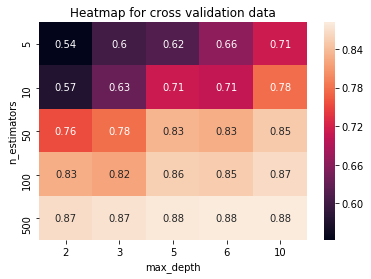

In [0]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

X=[]
Y=[]
auc  = []
Z1 = []

for b in base_models:
    for d in depth:
        model = RandomForestClassifier(max_depth = d, n_estimators = b, max_features = "sqrt")
        model.fit(X_train_bow, Y_train)
        X_cv_pred = model.predict_proba(X_cv_bow)[:,1]
        X_train_pred = model.predict_proba(X_train_bow)[:,1]
        X.append(b)
        Y.append(d)

    
        auc.append(roc_auc_score(Y_cv,X_cv_pred))
        Z1.append(roc_auc_score(Y_train,X_train_pred))
        
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': auc})
data_s = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_s,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()



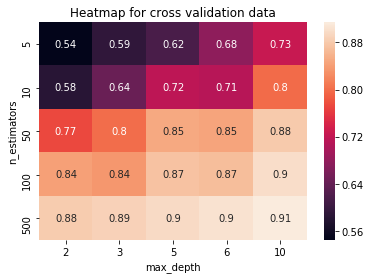

In [0]:
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z1})
data_s = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_s,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

In [0]:
#top 20 features 

features= count_vect.get_feature_names()
text=''

weight=model.feature_importances_
pos_w=np.argsort(weight)[::-1]
for i in pos_w[0:20]:
    print(features[i])
    text+=features[i]
    text+=' '

great
terrible
not
money
return
threw
worst
would
disappointed
best
waste
horrible
awful
refund
disappointing
bad
disappointment
worse
hoping
maybe


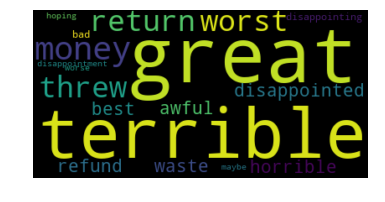

In [0]:

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [0]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

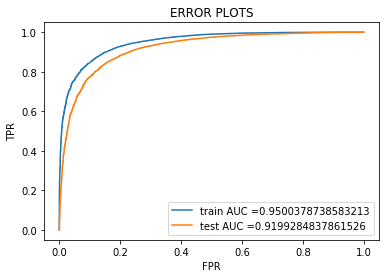

In [0]:
from sklearn.metrics import roc_curve, auc
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth = 10, n_estimators = 500, max_features = "sqrt", class_weight = "balanced")
model.fit(X_train_bow,Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_train_pred = batch_predict(model, X_train_bow)    
y_test_pred = batch_predict(model, X_test_bow)

train_fpr, train_tpr, thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, thresholds = roc_curve(Y_test,y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [0]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.7666366481589161 for threshold 0.504
Train confusion matrix


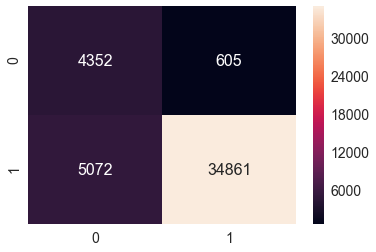

In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(Y_train, predict_with_best_t(y_train_pred, best_t)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')



Test confusion matrix


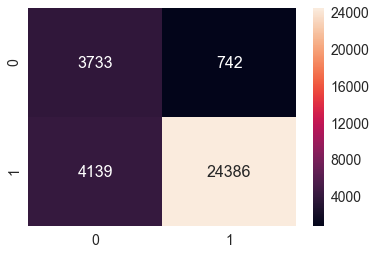

In [0]:
print("Test confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(Y_test, predict_with_best_t(y_test_pred, best_t)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

##  Apply RF on Tfidf

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=10, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

In [0]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


base_models = [5,10,50,100,500]
depth = [2,3,5,6,10]



param_grid={'n_estimators':base_models , 'max_depth':depth }
rf = RandomForestClassifier(max_features='sqrt')

model=GridSearchCV(rf,param_grid,scoring='roc_auc')
model.fit(X_train_tfidf,Y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
#Y_train_pred =  model.predict_proba(X_train_bow)[:,1]
#Y_cv_pred =  model.predict_proba(X_cv_bow)[:,1]
#train_auc.append(roc_auc_score(Y_train,Y_train_pred))

print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)

optimal n_estimators 500
optimal max_depth 10


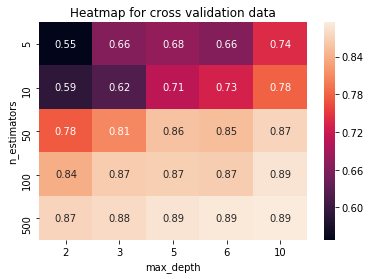

In [0]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

X=[]
Y=[]
auc  = []
Z1 = []

for b in base_models:
    for d in depth:
        model = RandomForestClassifier(max_depth = d, n_estimators = b, max_features = "sqrt")
        model.fit(X_train_tfidf, Y_train)
        X_cv_pred = model.predict_proba(X_cv_tfidf)[:,1]
        X_train_pred = model.predict_proba(X_train_tfidf)[:,1]
        X.append(b)
        Y.append(d)

    
        auc.append(roc_auc_score(Y_cv,X_cv_pred))
        Z1.append(roc_auc_score(Y_train,X_train_pred))
        
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': auc})
data_s = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_s,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()


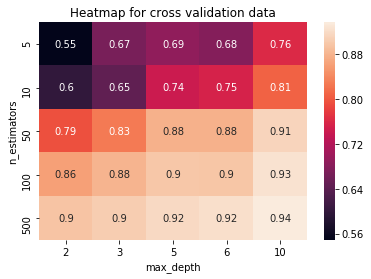

In [0]:
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z1})
data_s = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_s,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

In [0]:
#top 20 features 

features= count_vect.get_feature_names()
text=''

weight=model.feature_importances_
pos_w=np.argsort(weight)[::-1]
for i in pos_w[0:20]:
    print(features[i])
    text+=features[i]
    text+=' '

gardenvery
catagories
gatorade
deminishes
oilwarnings
amizon
dissolved
introductory
nondigestible
gnawed
amused
oilve
inspector
gland
nondescript
catalytic
appian
mimosa
merge
older


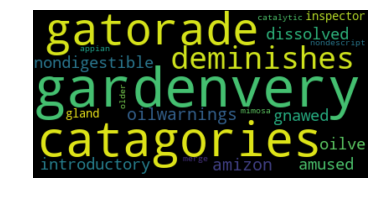

In [0]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [0]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

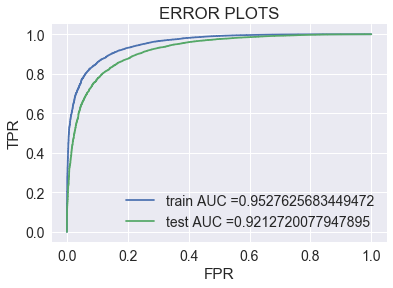

In [0]:
from sklearn.metrics import roc_curve, auc
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth = 10, n_estimators = 500, max_features = "sqrt", class_weight = "balanced")
model.fit(X_train_tfidf,Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_train_pred = batch_predict(model, X_train_tfidf)    
y_test_pred = batch_predict(model, X_test_tfidf)

train_fpr, train_tpr, thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, thresholds = roc_curve(Y_test,y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [0]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.7742518041908213 for threshold 0.508
Train confusion matrix


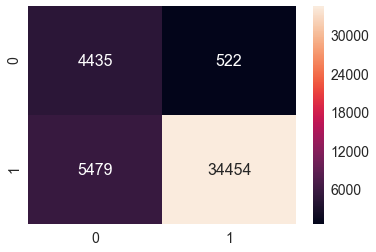

In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(Y_train, predict_with_best_t(y_train_pred, best_t)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


Test confusion matrix


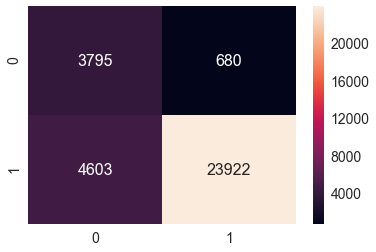

In [0]:
print("Test confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(Y_test, predict_with_best_t(y_test_pred, best_t)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Avg word2vec

In [0]:
import re

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [0]:

import gensim
list_of_sentance=[]
#for sent in final_40k['Text'].values:
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sentance.append(filtered_sentence)

In [0]:
w2v_model=gensim.models.Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)

In [0]:
w2v_words = list(w2v_model.wv.vocab)
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 44890/44890 [03:04<00:00, 243.09it/s]


44890
50


In [0]:

import gensim
list_of_sentance_cv=[]
#for sent in final_40k['Text'].values:
for sent in X_cv:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sentance_cv.append(filtered_sentence)

In [0]:
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 22110/22110 [01:32<00:00, 239.00it/s]


22110
50


In [0]:
import gensim
list_of_sentance_test=[]
#for sent in final_40k['Text'].values:
for sent in X_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sentance_test.append(filtered_sentence)

In [0]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 33000/33000 [02:39<00:00, 206.76it/s]


33000
50


In [0]:
X_train_w2v = sent_vectors
X_cv_w2v = sent_vectors_cv
X_test_w2v = sent_vectors_test

In [0]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


base_models = [5,10,50,100,500]
depth = [2,3,5,6,10]



param_grid={'n_estimators':base_models , 'max_depth':depth }
rf = RandomForestClassifier(max_features='sqrt')

model=GridSearchCV(rf,param_grid,scoring='roc_auc')
model.fit(X_train_w2v,Y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
#Y_train_pred =  model.predict_proba(X_train_bow)[:,1]
#Y_cv_pred =  model.predict_proba(X_cv_bow)[:,1]
#train_auc.append(roc_auc_score(Y_train,Y_train_pred))

print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)

optimal n_estimators 500
optimal max_depth 10


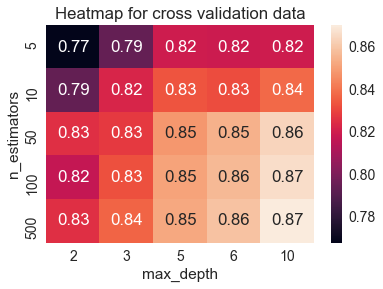

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

X=[]
Y=[]
auc  = []
Z1 = []

for b in base_models:
    for d in depth:
        model = RandomForestClassifier(max_depth = d, n_estimators = b, max_features = "sqrt")
        model.fit(X_train_w2v, Y_train)
        X_cv_pred = model.predict_proba(X_cv_w2v)[:,1]
        X_train_pred = model.predict_proba(X_train_w2v)[:,1]
        X.append(b)
        Y.append(d)

    
        auc.append(roc_auc_score(Y_cv,X_cv_pred))
        Z1.append(roc_auc_score(Y_train,X_train_pred))
        
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': auc})
data_s = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_s,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()


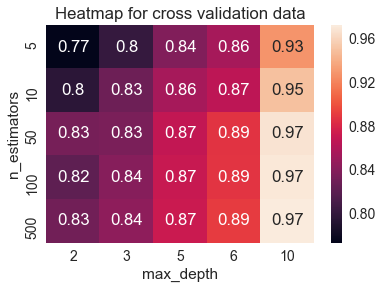

In [0]:
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z1})
data_s = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_s,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

In [0]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data[0] - data[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

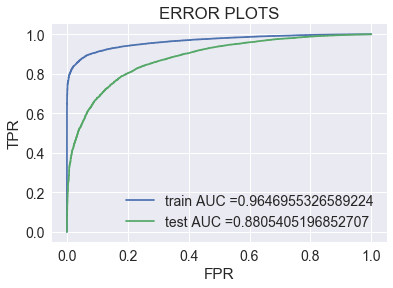

In [0]:
from sklearn.metrics import roc_curve, auc
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth = 10, n_estimators = 500, max_features = "sqrt", class_weight = "balanced")
model.fit(X_train_w2v,Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_train_pred = batch_predict(model, np.array(X_train_w2v))    
y_test_pred = batch_predict(model, np.array(X_test_w2v))

train_fpr, train_tpr, thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, thresholds = roc_curve(Y_test,y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [0]:
#top 20 features 

features= count_vect.get_feature_names()
text=''

weight=model.feature_importances_
pos_w=np.argsort(weight)[::-1]
for i in pos_w[0:20]:
    print(features[i])
    text+=features[i]
    text+=' '

abnormal
aaahs
abdomen
aand
ablaze
abby
abdominal
ablity
abnormalities
abbreviated
able
abandon
abc
ab
ability
aaaaah
aaaa
abeneficial
abigirl
abide


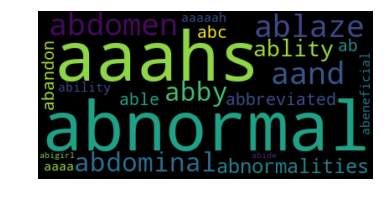

In [0]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

the maximum value of tpr*(1-fpr) 0.8358578993831209 for threshold 0.71
Train confusion matrix


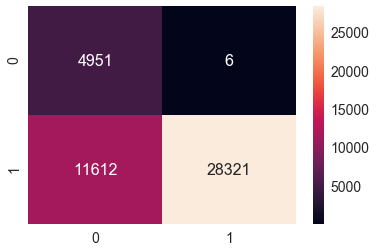

In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(Y_train, predict_with_best_t(y_train_pred, best_t)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Test confusion matrix


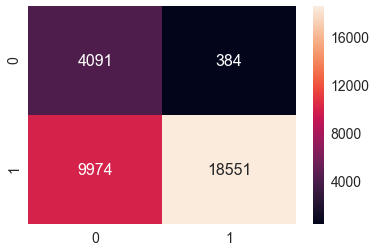

In [0]:
# Test confusion matrix
print("Test confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(Y_test, predict_with_best_t(y_test_pred, best_t)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Apply RF on word2vec

In [0]:
#tfidf weighted word2vec
model = TfidfVectorizer()
model.fit(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 44890/44890 [42:42<00:00, 22.15it/s]


In [0]:
tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 22110/22110 [17:47<00:00, 17.77it/s]


In [0]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 33000/33000 [25:47<00:00, 21.33it/s]


In [0]:
X_train_avg_w2v = sent_vectors
X_cv_avg_w2v = sent_vectors_cv
X_test_avg_w2v = sent_vectors_test

In [0]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


base_models = [5,10,50,100,500]
depth = [2,3,5,6,10]



param_grid={'n_estimators':base_models , 'max_depth':depth }
rf = RandomForestClassifier(max_features='sqrt')

model=GridSearchCV(rf,param_grid,scoring='roc_auc')
model.fit(X_train_avg_w2v,Y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
#Y_train_pred =  model.predict_proba(X_train_bow)[:,1]
#Y_cv_pred =  model.predict_proba(X_cv_bow)[:,1]
#train_auc.append(roc_auc_score(Y_train,Y_train_pred))

print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)

optimal n_estimators 500
optimal max_depth 10


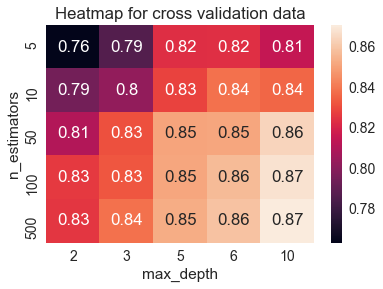

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

X=[]
Y=[]
auc  = []
Z1 = []

for b in base_models:
    for d in depth:
        model = RandomForestClassifier(max_depth = d, n_estimators = b, max_features = "sqrt")
        model.fit(X_train_avg_w2v, Y_train)
        X_cv_pred = model.predict_proba(X_cv_avg_w2v)[:,1]
        X_train_pred = model.predict_proba(X_train_avg_w2v)[:,1]
        X.append(b)
        Y.append(d)

    
        auc.append(roc_auc_score(Y_cv,X_cv_pred))
        Z1.append(roc_auc_score(Y_train,X_train_pred))
        
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': auc})
data_s = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_s,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

print("="*100)

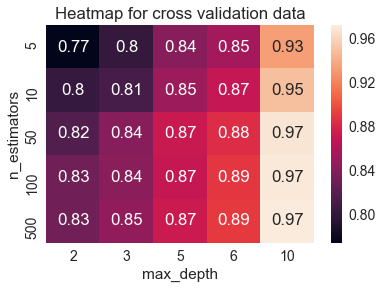

In [0]:
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z1})
data_s = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_s,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

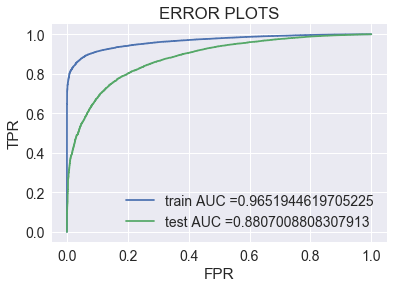

In [0]:
from sklearn.metrics import roc_curve, auc

model = RandomForestClassifier(max_depth = 10, n_estimators = 500, max_features = "sqrt", class_weight = "balanced")
model.fit(X_train_avg_w2v,Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_train_pred = batch_predict(model,np.array(X_train_avg_w2v))
y_test_pred = batch_predict(model,np.array( X_test_avg_w2v))

train_fpr, train_tpr, thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, thresholds = roc_curve(Y_test,y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [0]:
#top 20 features 

features= count_vect.get_feature_names()
text=''

weight=model.feature_importances_
pos_w=np.argsort(weight)[::-1]
for i in pos_w[0:20]:
    print(features[i])
    text+=features[i]
    text+=' '

abnormal
aand
aaahs
abdomen
ablaze
abby
ablity
abdominal
abnormalities
able
abbreviated
abandon
abc
ability
ab
aaaaah
abeneficial
aaaa
abide
abigirl


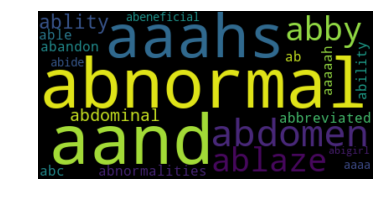

In [0]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

the maximum value of tpr*(1-fpr) 0.8372673613010285 for threshold 0.708
Train confusion matrix


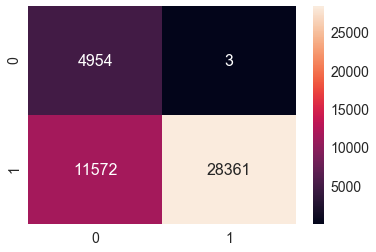

In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(Y_train, predict_with_best_t(y_train_pred, best_t)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


Test confusion matrix


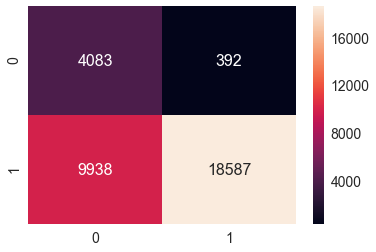

In [0]:
print("Test confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(Y_test, predict_with_best_t(y_test_pred, best_t)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Apply GBDT on BOW

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier


base_models = [5,10,50,100,120]
depth = [2,3,5,6,10]


param_grid={'n_estimators':base_models , 'max_depth':depth }
rf = XGBClassifier(booster='gbtree')

model=GridSearchCV(rf,param_grid,scoring='roc_auc')
model.fit(X_train_bow,Y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
#Y_train_pred =  model.predict_proba(X_train_bow)[:,1]
#Y_cv_pred =  model.predict_proba(X_cv_bow)[:,1]
#train_auc.append(roc_auc_score(Y_train,Y_train_pred))

print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)

optimal n_estimators 120
optimal max_depth 10


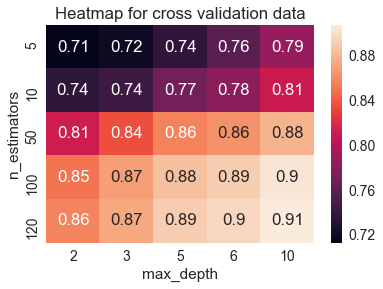

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

X=[]
Y=[]
auc  = []
Z1 = []

for b in base_models:
    for d in depth:
        model =XGBClassifier(max_depth = d, n_estimators = b,booster='gbtree')
        model.fit(X_train_bow, Y_train)
        X_cv_pred = model.predict_proba(X_cv_bow)[:,1]
        X_train_pred = model.predict_proba(X_train_bow)[:,1]
        X.append(b)
        Y.append(d)

    
        auc.append(roc_auc_score(Y_cv,X_cv_pred))
        Z1.append(roc_auc_score(Y_train,X_train_pred))
        
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': auc})
data_s = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_s,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

print("="*100)

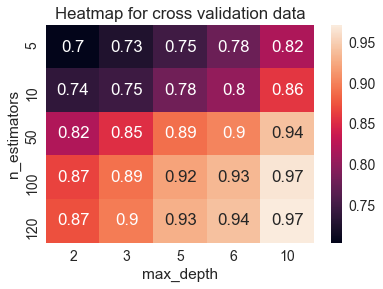

In [0]:
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z1})
data_s = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_s,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

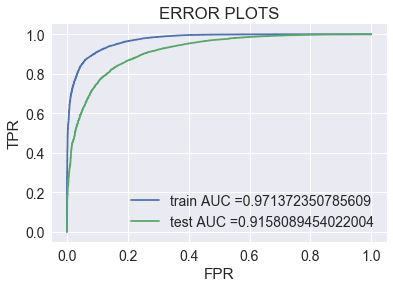

In [0]:
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier

model = XGBClassifier(max_depth = 10, n_estimators = 120,booster='gbtree' ,class_weight = "balanced")
model.fit(X_train_bow,Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(model, X_train_bow)    
y_test_pred = batch_predict(model, X_test_bow)

train_fpr, train_tpr, thresholds = roc_curve(Y_train,y_train_pred)
test_fpr, test_tpr, thresholds = roc_curve(Y_test,y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [0]:
#top 20 features 

features= count_vect.get_feature_names()
text=''

weight=model.feature_importances_
pos_w=np.argsort(weight)[::-1]
for i in pos_w[0:20]:
    print(features[i])
    text+=features[i]
    text+=' '

perfect
refund
favorite
loves
best
wonderful
great
worst
money
gross
delicious
highly
threw
excellent
awful
nice
worse
return
disgusting
amazing


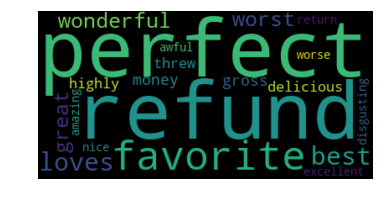

In [0]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

the maximum value of tpr*(1-fpr) 0.8213073521105285 for threshold 0.813
Train confusion matrix


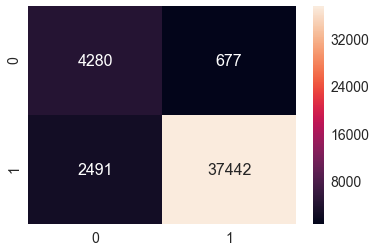

In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(Y_train, predict_with_best_t(y_train_pred, best_t)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


Test confusion matrix


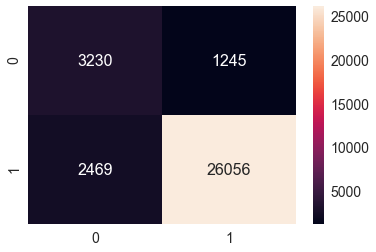

In [0]:
print("Test confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(Y_test, predict_with_best_t(y_test_pred, best_t)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Apply XGBOOST on Tdidf

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier


base_models = [5,10,50,100,120]
depth = [2,3,5,6,10]


param_grid={'n_estimators':base_models , 'max_depth':depth }
rf = XGBClassifier(booster='gbtree')

model=GridSearchCV(rf,param_grid,scoring='roc_auc')
model.fit(X_train_tfidf,Y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
#Y_train_pred =  model.predict_proba(X_train_tfidf)[:,1]
#Y_cv_pred =  model.predict_proba(X_cv_tfidf)[:,1]
#train_auc.append(roc_auc_score(Y_train,Y_train_pred))

print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)

optimal n_estimators 120
optimal max_depth 10


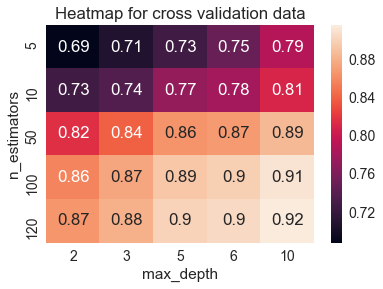

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

X=[]
Y=[]
auc  = []
Z1 = []

for b in base_models:
    for d in depth:
        model =XGBClassifier(max_depth = d, n_estimators = b,booster='gbtree')
        model.fit(X_train_tfidf, Y_train)
        X_cv_pred = model.predict_proba(X_cv_tfidf)[:,1]
        X_train_pred = model.predict_proba(X_train_tfidf)[:,1]
        X.append(b)
        Y.append(d)

    
        auc.append(roc_auc_score(Y_cv,X_cv_pred))
        Z1.append(roc_auc_score(Y_train,X_train_pred))
        
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': auc})
data_s = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_s,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

print("="*100)

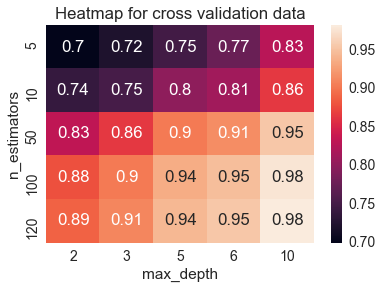

In [0]:
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z1})
data_s = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_s,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

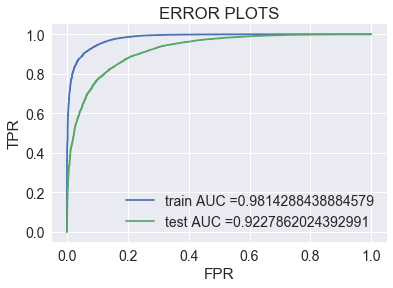

In [0]:

from sklearn.metrics import roc_curve, auc

model = XGBClassifier(max_depth = 10, n_estimators = 120,booster='gbtree' ,class_weight = "balanced")
model.fit(X_train_tfidf,Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_train_pred = batch_predict(model, X_train_tfidf)    
y_test_pred = batch_predict(model, X_test_tfidf)

train_fpr, train_tpr, thresholds = roc_curve(Y_train,y_train_pred)
test_fpr, test_tpr, thresholds = roc_curve(Y_test,y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [0]:
#top 20 features 

features= tf_idf_vect.get_feature_names()
text=''

weight=model.feature_importances_
pos_w=np.argsort(weight)[::-1]
for i in pos_w[0:20]:
    print(features[i])
    text+=features[i]
    text+=' '

not disappointed
worst
return
refund
threw
loves
awful
perfect
delicious
not buy
horrible
gross
worse
waste
disgusting
not worth
trash
highly
money
sorry


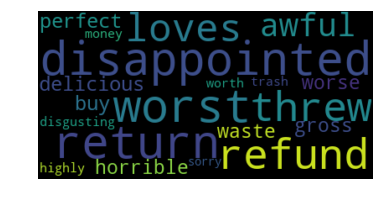

In [0]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

the maximum value of tpr*(1-fpr) 0.8548227399312246 for threshold 0.801
Train confusion matrix


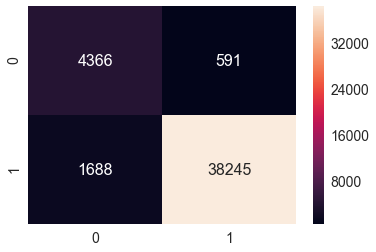

In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(Y_train, predict_with_best_t(y_train_pred, best_t)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Test confusion matrix


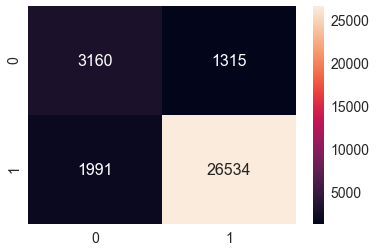

In [0]:
# Test confusion matrix
print("Test confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(Y_test, predict_with_best_t(y_test_pred, best_t)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Apply XGBOOST on avg w2v

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier


base_models = [5,10,50,100,120]
depth = [2,3,5,6,10]


param_grid={'n_estimators':base_models , 'max_depth':depth }
rf = XGBClassifier(booster='gbtree')

model=GridSearchCV(rf,param_grid,scoring='roc_auc')
model.fit(np.array(X_train_w2v),Y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
#Y_train_pred =  model.predict_proba(X_train_w2v)[:,1]
#Y_cv_pred =  model.predict_proba(X_cv_w2v)[:,1]
#train_auc.append(roc_auc_score(Y_train,Y_train_pred))

print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)

optimal n_estimators 120
optimal max_depth 6


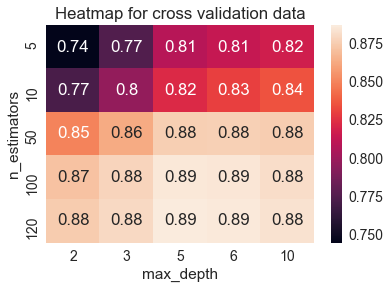

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

X=[]
Y=[]
auc  = []
Z1 = []

for b in base_models:
    for d in depth:
        model =XGBClassifier(max_depth = d, n_estimators = b,booster='gbtree')
        model.fit(np.array(X_train_w2v), Y_train)
        X_cv_pred = model.predict_proba(X_cv_w2v)[:,1]
        X_train_pred = model.predict_proba(X_train_w2v)[:,1]
        X.append(b)
        Y.append(d)

    
        auc.append(roc_auc_score(Y_cv,X_cv_pred))
        Z1.append(roc_auc_score(Y_train,X_train_pred))
        
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': auc})
data_s = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_s,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

print("="*100)

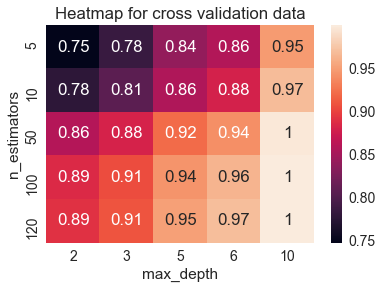

In [0]:
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z1})
data_s = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_s,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

In [0]:
#X_train_w2v = np.array(sent_vectors)
#X_cv_w2v =np.array(sent_vectors_cv)
#X_test_w2v = np.array(sent_vectors_test)

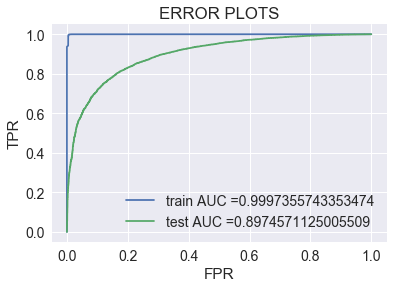

In [0]:
model = XGBClassifier(max_depth = 10, n_estimators = 120,booster='gbtree' ,class_weight = "balanced")
model.fit(np.array(X_train_w2v),Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_train_pred = batch_predict(model,np.array( X_train_w2v))    
y_test_pred = batch_predict(model,np.array( X_test_w2v))

train_fpr, train_tpr, thresholds = roc_curve(Y_train,y_train_pred)
test_fpr, test_tpr, thresholds = roc_curve(Y_test,y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

the maximum value of tpr*(1-fpr) 0.9919339929685834 for threshold 0.726
Train confusion matrix


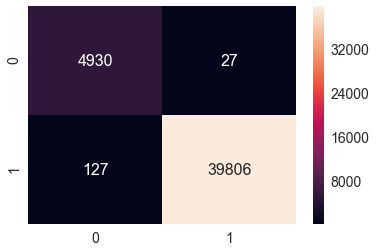

In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(Y_train, predict_with_best_t(y_train_pred, best_t)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


Test confusion matrix


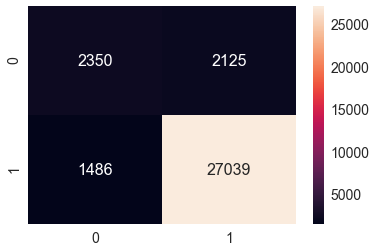

In [0]:
print("Test confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(Y_test, predict_with_best_t(y_test_pred, best_t)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Apply XGBOOST on W2v tfidf vectors

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier


base_models = [5,10,50,100,120]
depth = [2,3,5,6,10]


param_grid={'n_estimators':base_models , 'max_depth':depth }
rf = XGBClassifier(booster='gbtree')

model=GridSearchCV(rf,param_grid,scoring='roc_auc')
model.fit(np.array(X_train_avg_w2v),Y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
#Y_train_pred =  model.predict_proba(X_train_avg_w2v)[:,1]
#Y_cv_pred =  model.predict_proba(X_cv_avg_w2v)[:,1]
#train_auc.append(roc_auc_score(Y_train,Y_train_pred))

print("optimal n_estimators",model.best_estimator_.n_estimators)
print("optimal max_depth",model.best_estimator_.max_depth)

optimal n_estimators 120
optimal max_depth 6


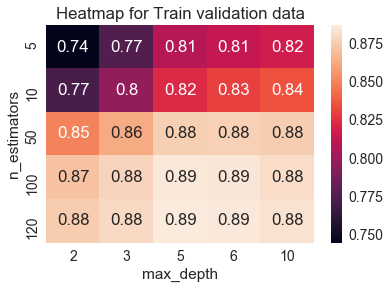

In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

X=[]
Y=[]
auc  = []
Z1 = []

for b in base_models:
    for d in depth:
        model =XGBClassifier(max_depth = d, n_estimators = b,booster='gbtree')
        model.fit(np.array(X_train_avg_w2v), Y_train)
        X_cv_pred = model.predict_proba(X_cv_avg_w2v)[:,1]
        X_train_pred = model.predict_proba(X_train_avg_w2v)[:,1]
        X.append(b)
        Y.append(d)

    
        auc.append(roc_auc_score(Y_cv,X_cv_pred))
        Z1.append(roc_auc_score(Y_train,X_train_pred))
        
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': auc})
data_s = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_s,annot=True)
plt.title('Heatmap for Train validation data')
plt.show()

print("="*100)

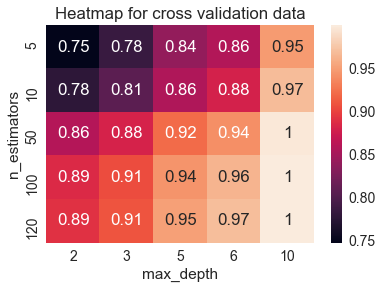

In [0]:
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z1})
data_s = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_s,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

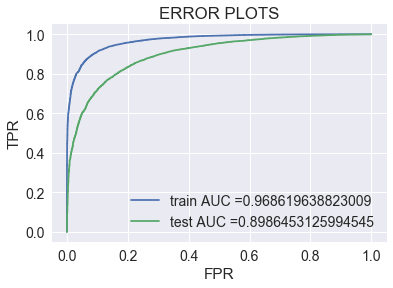

In [0]:
model = XGBClassifier(max_depth = 6, n_estimators = 120,booster='gbtree' ,class_weight = "balanced")
model.fit(np.array(X_train_avg_w2v),Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_train_pred = batch_predict(model,np.array( X_train_avg_w2v))    
y_test_pred = batch_predict(model,np.array( X_test_avg_w2v))

train_fpr, train_tpr, thresholds = roc_curve(Y_train,y_train_pred)
test_fpr, test_tpr, thresholds = roc_curve(Y_test,y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

the maximum value of tpr*(1-fpr) 0.8218851304601741 for threshold 0.823
Train confusion matrix


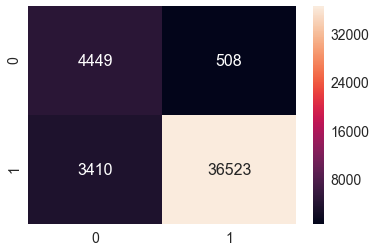

In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(Y_train, predict_with_best_t(y_train_pred, best_t)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


Test confusion matrix


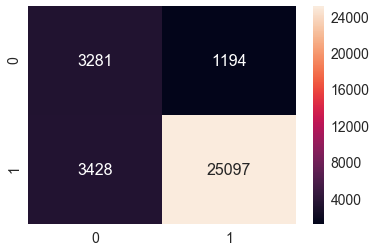

In [0]:
print("Test confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(Y_test, predict_with_best_t(y_test_pred, best_t)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Conclusion


1) RF and Xgboost gives pretty good performance comparing to other models although its a bit slow.
2) Performance on TFIDF-W2V models was poor.
3) Plotted heat maps with the hyperparameter tuning for better understanding of results

In [0]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Model","Vectorizer","optimal max_depth", "optimal n_estimators", "AUC"]
x.add_row(['Random Forest','BOW','10','500','0.92'])
x.add_row(['Random Forest','TFIDF','10','500','0.93'])
x.add_row(['Random Forest','AVG W2vec','10','500','0.88'])
x.add_row(['Random Forest','TFIDF W2vec','10','500','0.89'])
x.add_row(['XGBOOST GBDT','Bow','10','120','0.92'])
x.add_row(['XGBOOST GBDT','TFIDF','10','120','0.93'])
x.add_row(['XGBOOST GBDT','AVG W2Vec','10','120','0.89'])
x.add_row(['XGBOOST GBDT','TFIDF W2Vec','6','120','0.89'])
print(x)

+---------------+-------------+-------------------+----------------------+------+
|     Model     |  Vectorizer | optimal max_depth | optimal n_estimators | AUC  |
+---------------+-------------+-------------------+----------------------+------+
| Random Forest |     BOW     |         10        |         500          | 0.92 |
| Random Forest |    TFIDF    |         10        |         500          | 0.93 |
| Random Forest |  AVG W2vec  |         10        |         500          | 0.88 |
| Random Forest | TFIDF W2vec |         10        |         500          | 0.89 |
|  XGBOOST GBDT |     Bow     |         10        |         120          | 0.92 |
|  XGBOOST GBDT |    TFIDF    |         10        |         120          | 0.93 |
|  XGBOOST GBDT |  AVG W2Vec  |         10        |         120          | 0.89 |
|  XGBOOST GBDT | TFIDF W2Vec |         6         |         120          | 0.89 |
+---------------+-------------+-------------------+----------------------+------+
